<a href="https://colab.research.google.com/github/sverdoot/DL-in-NLP-course/blob/master/workshop%203/task3_word_level_lm_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Word-level language model

In the previous tasks you have written character-level language model. Time has come to grow up.

Word language models face a lot of new problems for you to solve. There are some of them:
  * How to read long texts (Gbs of data)
  * How to build vocabulry (and to effectively reduce its size)
  * How to deal with out-of-vocabulary (OOV) words # random vectors?
  * How to construct batch of _uncorrelated_ examples (not from the same text)
  * How and when to drop RNN state
  * What special tokens should be used? BOS? EOS?

**Results of this task:**
  * Text preprocessing
  * Batcher
  * Trained language model:
    * model should use truncated backpropagation through time
    * model should drop RNN state between different documents (eg. wikipedia articles)
  * Test set perplexity

**Additional points:**
  * Text preprocessing and batching that works with large files (does not load all the file to memory)
  * AWD-LSTM or other uncommon RNN architectures (SRU, QRNN)
  * Use popular dataset 

It is becoming common to use [byte-pair encoding](https://github.com/google/sentencepiece) to solve vocabulary problem. Use it! Here is an [example](https://github.com/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb).

In [0]:
!pip install sentencepiece

In [0]:
import sentencepiece as spm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch.autograd import Variable
import random
import matplotlib.pyplot as plt
import torch.utils.data as utils
import time
import csv
import pandas as pd
import time
import math

In [0]:
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)

using device: cuda


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Download & preprocess. Here sentencepiece + vocabulary restriction is used. Only tokens with 200+ frequency contains in vocabulary.
I get data from economic news articles. Contributors read snippets of news articles. Dataset contains these artilces as well as the dates, source titles, and text. Dates range from 1951 to 2014.

In [0]:
!wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Full-Economic-News-DFE-839861.csv

--2019-04-13 16:27:41--  https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Full-Economic-News-DFE-839861.csv
Resolving d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)... 13.35.115.97, 13.35.115.48, 13.35.115.27, ...
Connecting to d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)|13.35.115.97|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12383529 (12M) [application/octet-stream]
Saving to: ‘Full-Economic-News-DFE-839861.csv.1’

Full-Economic-News- 100%[===================>]  11.81M  45.2MB/s    in 0.3s    

2019-04-13 16:27:41 (45.2 MB/s) - ‘Full-Economic-News-DFE-839861.csv.1’ saved [12383529/12383529]



In [0]:
df = pd.read_csv('Full-Economic-News-DFE-839861.csv',encoding='latin-1')
all_texts = df['text'] #you can also use df['column_name']

In [0]:
val_texts = list(all_texts)[1000:2000]
all_texts = all_texts[0:1000]

In [0]:
len(all_texts)

1000

In [0]:
print('Longest text consists of {} symbols'.format(max([len(i) for i in all_texts])))
print('Shortest text consists of {} symbols'.format(min([len(i) for i in all_texts])))
print('Average text consists of {} symbols'.format(int(np.average([len(i) for i in all_texts]))))

Longest text consists of 4988 symbols
Shortest text consists of 113 symbols
Average text consists of 1378 symbols


Download all texts in text.txt, later use in sentensepiecetrainer

In [0]:
myfile = open('text.txt', 'w')
for line in all_texts:
    myfile.write("%s\n" % line.lower().replace('</br></br>',' '))
myfile.close()

In [0]:
spm.SentencePieceTrainer.train('--input=text.txt --model_prefix=m --vocab_size=2000')
sp = spm.SentencePieceProcessor()
sp.load('m.model')
# Gets all tokens as Python list.
vocabs = [sp.id_to_piece(id) for id in range(sp.get_piece_size())]
print('Vocab consists of {} words'.format(len(vocabs)))

Vocab consists of 2000 words


Compute the frequency of each token in the training data.

In [0]:
freq = {}
with open('text.txt', 'r') as f:
    for line in f:
        line = line.rstrip()
        for piece in sp.encode_as_pieces(line):
            freq.setdefault(piece, 0)
            freq[piece] += 1

Let's reduce the vocabulary, only words with frequency more than 200 remain, only $\sim 300+$ words remain.

If the subword would be unknown, "UNK"  token would be used

In [0]:
s = 0
for i in freq:
    if freq[i] > 200:
        s += 1
print(s)

312


In [0]:
print(sp.encode_as_pieces('this is a test.'))
print(sp.encode_as_pieces('hello world football putin russia'))
print(len(vocabs))
vocabs = list(filter(lambda x : x in freq and freq[x] > 200, vocabs))
sp.set_vocabulary(vocabs)
print(sp.encode_as_ids('this is a test.'))
print(sp.encode_as_pieces('hello world football putin russia'))
print(len(vocabs))

['▁this', '▁is', '▁a', '▁t', 'est', '.']
['▁he', 'll', 'o', '▁world', '▁f', 'o', 'o', 't', 'b', 'all', '▁put', 'in', '▁ru', 's', 's', 'ia']
2000
[68, 24, 7, 177, 211, 4]
['▁he', 'll', 'o', '▁w', 'or', 'l', 'd', '▁f', 'o', 'o', 't', 'b', 'al', 'l', '▁p', 'ut', 'in', '▁', 'r', 'us', 's', 'i', 'a']
312


In [0]:
vocabs.append('<UNK>')
vocabs.sort()
print(vocabs)

['"', '&', "'", ')', ',', '-', '.', '."', '0', '1', '2', '3', '4', '5', '5%', '6', '7', '8', '9', ':', '<UNK>', 'a', 'able', 'age', 'al', 'an', 'and', 'ar', 'as', 'at', 'ate', 'ation', 'b', 'c', 'ce', 'ch', 'ck', 'com', 'd', 'e', 'ed', 'el', 'en', 'end', 'ent', 'er', 'ers', 'es', 'est', 'et', 'f', 'g', 'h', 'ha', 'hi', 'i', 'ic', 'id', 'if', 'ight', 'il', 'im', 'in', 'ing', 'ion', 'ir', 'is', 'ist', 'it', 'ity', 'ive', 'k', 'l', 'la', 'le', 'li', 'll', 'lo', 'ly', 'm', 'man', 'many', 'ment', 'min', 'n', 'ne', 'o', 'ol', 'on', 'or', 'p', 'qu', 'r', 'ra', 're', 'ri', 'ro', 's', 'se', 'st', 't', 'ter', 'term', 'th', 'the', 'ting', 'u', 'ul', 'um', 'un', 'ure', 'us', 'ut', 'v', 've', 'ver', 'w', 'x', 'y', 'year', 'z', '▁', '▁"', '▁$1', '▁(', '▁--', '▁0.', '▁1.', '▁19', '▁2', '▁3', '▁4', '▁5', '▁a', '▁about', '▁after', '▁against', '▁al', '▁all', '▁also', '▁an', '▁analysts', '▁and', '▁are', '▁as', '▁at', '▁average', '▁b', '▁back', '▁bank', '▁banks', '▁be', '▁because', '▁been', '▁billion', '▁

Create own dict of indexes of words from vocab + reversed

In [0]:
idx_2_word = dict(enumerate(vocabs))
word_2_idx = {v: k for k, v in idx_2_word.items()}

##Batcher

In [0]:
class Batch:
    def __init__(self, word_2_idx, idx_2_word, all_texts, batch_size, length):
        self.word_2_idx = word_2_idx
        self.idx_2_word = idx_2_word
        self.length = length
        self.data = [self.preprocess(sp.encode_as_ids(all_texts[i])) for i in range(len(all_texts))]
        self.batch_size =  batch_size
        self.text = [-1] * self.batch_size
        self.current_symbol = [0] * self.batch_size
        self.new = [False] * self.batch_size
        
    def preprocess(self, sequence):
        return [i if i in self.idx_2_word else self.word_2_idx['<UNK>'] for i in sequence]
    
    def get_index(self):
        '''
        get index of random appropriate text
        '''
        i = random.randint(0, len(self.data)-1)
        current_len = len(self.data[i])
        while (current_len < self.length):
            i = random.randint(0, len(self.data)-1)
            current_len = len(self.data[i])
        return i
        
    def make_batch(self):
        '''
        inputs: None
        outputs: torch tensor [batch_size x self.longest-1] x 2: sample : pred + new text or not
        '''
        for i in range(self.batch_size):
            if self.text[i] == -1 or (len(self.data[self.text[i]]) <= self.current_symbol[i]+ self.length + 1):
                self.text[i] = self.get_index()
                self.current_symbol[i] = 0
                self.new[i] = True
            else:
                self.new[i] = False
            
        sample = torch.LongTensor(self.batch_size, self.length-1)
        pred = torch.LongTensor(self.batch_size, self.length-1)
        
        for i in range(self.batch_size):# make batch
            s = torch.Tensor(self.data[self.text[i]][self.current_symbol[i]:self.current_symbol[i]+self.length])
            self.current_symbol[i] += self.length
            sample[i] = (s[:-1])
            pred[i] = (s[1:])
            
        sample = sample.cuda()
        pred = pred.cuda()
        
        return sample, pred, self.new

## Model

In [0]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(self.input_size, self.hidden_size)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.n_layers)
        self.decoder = nn.Linear(self.hidden_size, self.output_size)
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = self.encoder(x)
        out, hidden = self.lstm(x.view(x.size(1), batch_size, -1), hidden)
        out = self.decoder(out)#.view(batch_size, -1))
        return out, hidden
      
    def init_hidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device, requires_grad=False),\
            torch.zeros(self.n_layers, batch_size, self.hidden_size, device = device, requires_grad=False)

## Parameters

In [0]:
batch_size = 256
length = 50
lr = 0.003
input_size = len(word_2_idx)
hidden_size = 256
n_layers = 3
n_batchs = 7500
print_every = 50

In [0]:
model = Net(input_size, hidden_size, input_size, n_layers).to(device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
loss = torch.tensor(0)

In [0]:
train_batcher = Batch(word_2_idx, idx_2_word, all_texts, batch_size, length)
val_batcher = Batch(word_2_idx, idx_2_word, val_texts, batch_size, length)

In [0]:
tr_n_batches = sum([len(x) for x in all_texts]) // (batch_size * length)
val_n_batches = sum([len(x) for x in val_texts]) // (batch_size * length)

In [0]:
tr_n_batches, val_n_batches

(107, 108)

## Train

In [0]:
def timeSince(since):
    now = time.clock()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def run_batch(hidden, inp, target, new):
   
    model.zero_grad()
    loss = 0
    
    for i in range(batch_size):# if text changed, hidden state related to it is setting to zeros  
        if new[i]:
            hidden[0][:,i,:] = 0
            hidden[1][:,i,:] = 0
    
    #for i in range(inp.shape[1]-1):
    #    output, hidden = model(inp[:,i],hidden)
    #    loss += criterion(output.view(batch_size,-1), target[:,i])
    output, hidden = model(inp, hidden)
    loss = criterion(output.view(batch_size * inp.size(1),  output.size(2)), target.view(batch_size * inp.size(1)))  
    
    if model.training:
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    
    return (hidden[0].data, hidden[1].data), output, loss.item() #/ length

In [0]:
start_time = time.clock()
tr_losses = []
val_losses = []
n_epochs = 20
loss_ep = []
tr_perp_ep = []
val_perp_ep = []
hidden = model.init_hidden(batch_size)
for epoch in range(n_epochs):
    model.train()
    for bat in range(1, tr_n_batches + 1):
        hidden, out, loss = run_batch(hidden, *train_batcher.make_batch())
        tr_losses.append(loss)
        #perplexity.append(np.exp(losses[-1]))
        if bat % print_every == 0:
            print('bat {},   \tloss {}'.format(bat, tr_losses[-1]))
            print('time passed %s:' %(timeSince(start_time)))
    model.eval()
    for bat in range(1, val_n_batches + 1):
        hidden, out, loss = run_batch(hidden, *val_batcher.make_batch())
        val_losses.append(loss)
    loss_ep.append(sum(tr_losses[-tr_n_batches:]) / tr_n_batches)
    tr_losses = []
    tr_perp_ep.append(math.exp(loss_ep[-1]))
    val_perp_ep.append(math.exp(sum(val_losses[-val_n_batches:]) / val_n_batches))
    val_losses = []
    print('epoch {},   \tloss {} \ttrain perplexity {}, validation perplexity {}'.format(epoch, loss_ep[-1], tr_perp_ep[-1], val_perp_ep[-1]))
    print('time passed %s:' %(timeSince(start_time)))

bat 50,   	loss 4.501490592956543
time passed 0m 4s:
bat 100,   	loss 4.129063129425049
time passed 0m 9s:
epoch 0,   	loss 4.47627026121193 	train perplexity 87.90619334635645, validation perplexity 60.65789259095709
time passed 0m 13s:
bat 50,   	loss 3.8759350776672363
time passed 0m 17s:
bat 100,   	loss 3.7449371814727783
time passed 0m 22s:
epoch 1,   	loss 3.8839872796958854 	train perplexity 48.61768140676685, validation perplexity 42.07910824941413
time passed 0m 26s:
bat 50,   	loss 3.6359119415283203
time passed 0m 30s:
bat 100,   	loss 3.5514543056488037
time passed 0m 35s:
epoch 2,   	loss 3.6461395348343895 	train perplexity 38.32642227007242, validation perplexity 35.864803080792775
time passed 0m 39s:
bat 50,   	loss 3.5490384101867676
time passed 0m 43s:
bat 100,   	loss 3.507286787033081
time passed 0m 48s:
epoch 3,   	loss 3.529345773090826 	train perplexity 34.10165009804902, validation perplexity 33.21256154893918
time passed 0m 52s:
bat 50,   	loss 3.4491770267486

In [0]:
torch.save(model, 'gdrive/My Drive/Colab Notebooks/subword_lang_33.dms')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
torch.save(optimizer, 'gdrive/My Drive/Colab Notebooks/adam_subword_lang_33.dms')

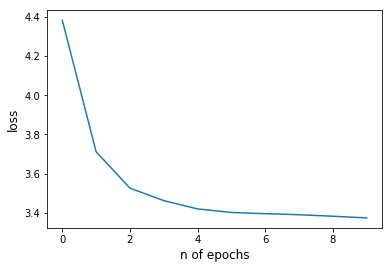

In [0]:
plt.plot(range(len(loss_ep)), loss_ep)
plt.xlabel("n of epochs", fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.show()

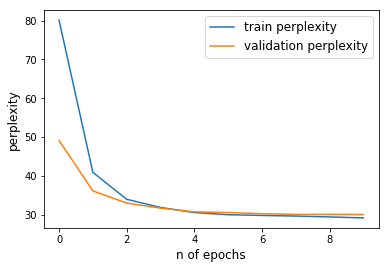

In [0]:
plt.plot(range(len(tr_perp_ep)), tr_perp_ep, label='train perplexity')
plt.plot(range(len(val_perp_ep)), val_perp_ep, label='validation perplexity')
plt.xlabel("n of epochs", fontsize=12)
plt.ylabel("perplexity", fontsize=12)
plt.legend(fontsize=12)
plt.show()